# Main

This model will take in a valence-arousal vector and a Bouba-Kiki vector. It will then output an encoded earcon representation, which will be passed to the MusicGen Decoder to generate the final earcon.

The output of the MusicGen Decoder will then be encoded by EncodecFeatureExtractor, and the vectors will be used to calculate the loss

In [1]:
# import relevant libraries
from transformers import EncodecFeatureExtractor
from utils.musicgen_model import *
from utils.musicgen_utils import *
from utils import *
import pandas as pd
import numpy as np
import ast
import clip
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pd.set_option('display.max_columns', None)

## Dataset

Each row in the dataset will consist of:
- An Earcon represented by an Encodec vector
- An image represented in a Valence Arousal Vector
- A Bouba-Kiki Value derived from the image
- A Pseudoword

The rows will be paired by cosine similarity between the Earcon's Encodec vector and the VA Vector from the image. The Bouba-Kiki Value and Pseudoword will be generated after the images are paired with the audio

### Earcons

In [3]:
# load in earcons
earcons = pd.read_csv('dataset\earcon_dataset\earcon_dataset.csv')

earcons['query'] = earcons['query'].apply(ast.literal_eval)
earcons["query"] = earcons["query"].apply(lambda x: x[0])

earcons = earcons[["query", "name"]]

earcons["filepaths"] = earcons["name"].apply(lambda x: f"dataset/earcon_dataset/earcons/{x}")

earcons

,query,name,filepaths
0,bright,Power_Up_Bright_A.wav,dataset/earcon_dataset/earcons/Power_Up_Bright...
1,bright,Magic_Spell_06.wav,dataset/earcon_dataset/earcons/Magic_Spell_06.wav
2,bright,Hand_Bells_High-C_Single.wav,dataset/earcon_dataset/earcons/Hand_Bells_High...
3,bright,Hand_Bells_G#_Ab_Single.wav,dataset/earcon_dataset/earcons/Hand_Bells_G#_A...
4,bright,Hand_Bells_A#_Bb_Single.wav,dataset/earcon_dataset/earcons/Hand_Bells_A#_B...
...,...,...,...
642,warm,warm_basssynth_4101.wav,dataset/earcon_dataset/earcons/warm_basssynth_...
643,warm,warm_basssynth_4001.wav,dataset/earcon_dataset/earcons/warm_basssynth_...
644,warm,31WarmStrings.wav,dataset/earcon_dataset/earcons/31WarmStrings.wav
645,warm,11WarmBrass.wav,dataset/earcon_dataset/earcons/11WarmBrass.wav


In [4]:
import librosa

# Load the audio files and store them in a list
audio_data = []
audio_paths = earcons["filepaths"].tolist()

# Load audio files and determine the maximum length, ensuring mono audio
max_length = 0
for path in audio_paths:
    temp, _ = librosa.load(path, sr=24000, mono=True)
    audio_data.append(temp)
    if len(temp) > max_length:
        max_length = len(temp)

Some basic EDA to determine what is the best output vector size should be used to extract features from the audio

In [5]:
# extract audio features with encodec
encodec = EncodecFeatureExtractor(feature_size=1)

features = encodec(audio_data, sampling_rate=24000, return_tensors="pt", padding=True)

# Calculate the longest feature
longest_feature = len(max(features['input_values'], key=lambda x: torch.count_nonzero(x))[0])

# Calculate the average feature length
average_feature_length = sum(torch.count_nonzero(x) for x in features['input_values']) / len(features['input_values'])

# Calculate the minimum feature length
min_feature_length = min(torch.count_nonzero(x) for x in features['input_values'])

# Calculate the 90th percentile feature length
percentile_90 = np.percentile([torch.count_nonzero(x).item() for x in features['input_values']], 90)

# Calculate the 10th percentile feature length
percentile_10 = np.percentile([torch.count_nonzero(x).item() for x in features['input_values']], 10)


print(f"Longest Feature Length: {longest_feature}")
print(f"Average Feature Length: {average_feature_length:.2f}")
print(f"Shortest Feature Length: {min_feature_length}")
print(f"90th Percentile: {percentile_90:.2f}")
print(f"10th Percentile: {percentile_10:.2f}")

Longest Feature Length: 1465856
Average Feature Length: 68692.56
Shortest Feature Length: 627
90th Percentile: 154435.20
10th Percentile: 13178.40


In [6]:
# Calculate the proportion of features fully covered by the length set to 131072
fully_covered_length = 131072
fully_covered_count = sum(1 for x in features['input_values'] if torch.count_nonzero(x) <= fully_covered_length)
fully_covered_percentile = (fully_covered_count / len(features['input_values'])) * 100


print(f"Fully Covered Percentile: {fully_covered_percentile:.3f}")

Fully Covered Percentile: 86.244


At a max_length of 131072 (2<sup>17</sup>), 86.244% of the features are fully included. Hence, we will use this value as our max_length

In [7]:
# extract features with encodec
encodec = EncodecFeatureExtractor(feature_size=1)

audio_features = encodec(
    audio_data,
    sampling_rate=24000,
    return_tensors="pt",
    max_length=131072,
    truncation=True
)

Since the output vectors are shaped as {"padding_mask": [[tensor]], "input_values": [[tensor]]}: the padding mask values will be multiplied by the input values to get the masked values

In [8]:
padding_mask = audio_features['padding_mask']
input_values = audio_features['input_values']

# Expand the padding mask to match the input_values shape
# Add a dimension for the feature axis
expanded_mask = padding_mask.unsqueeze(1)  # Shape: (batch_size, 1, sequence_length)

# Multiply the input values by the expanded mask
masked_input_values = input_values * expanded_mask  # Element-wise multiplication

# Output the masked input values
print(masked_input_values.shape)

del audio_features

torch.Size([647, 1, 131072])


After getting the audio features, a pooling operation is used to convert the output vector size to match CLIP's output vector size to facillate cosine similarity later

Max pooling was chosen over mean pooling due to a better distribution of earcons after cosine similarity was conducted

In [9]:
batch_size, _, original_size = masked_input_values.shape
target_size = 512
chunk_size = original_size // target_size

# Reshape and compute pooling
# pooled_tensor = masked_input_values.view(batch_size, target_size, chunk_size).mean(dim=2)  # Mean pooling
pooled_tensor = masked_input_values.view(batch_size, target_size, chunk_size).max(dim=2).values  # Max pooling

# Remove the singleton dimension (optional, if you want the final size to be [647, 512])
pooled_tensor = pooled_tensor.squeeze(1)

# Output the shape
print("Original size:", masked_input_values.shape)
print("Pooled size:", pooled_tensor.shape)

Original size: torch.Size([647, 1, 131072])
Pooled size: torch.Size([647, 512])


In [10]:
# Add the features to the dataframe
earcons["features"] = pooled_tensor.tolist()
earcons

,query,name,filepaths,features
0,bright,Power_Up_Bright_A.wav,dataset/earcon_dataset/earcons/Power_Up_Bright...,"[1.0311479854863137e-05, 4.748003993881866e-05..."
1,bright,Magic_Spell_06.wav,dataset/earcon_dataset/earcons/Magic_Spell_06.wav,"[0.701808750629425, 0.6881600618362427, 0.7431..."
2,bright,Hand_Bells_High-C_Single.wav,dataset/earcon_dataset/earcons/Hand_Bells_High...,"[0.00036849058233201504, 9.572050475981086e-05..."
3,bright,Hand_Bells_G#_Ab_Single.wav,dataset/earcon_dataset/earcons/Hand_Bells_G#_A...,"[0.0001851564593380317, 0.0002682538179215044,..."
4,bright,Hand_Bells_A#_Bb_Single.wav,dataset/earcon_dataset/earcons/Hand_Bells_A#_B...,"[0.0002253772399853915, 0.0005031696055084467,..."
...,...,...,...,...
642,warm,warm_basssynth_4101.wav,dataset/earcon_dataset/earcons/warm_basssynth_...,"[0.12015484273433685, 0.2755824327468872, 0.35..."
643,warm,warm_basssynth_4001.wav,dataset/earcon_dataset/earcons/warm_basssynth_...,"[0.18054038286209106, 0.3994967043399811, 0.58..."
644,warm,31WarmStrings.wav,dataset/earcon_dataset/earcons/31WarmStrings.wav,"[0.00021004144218750298, 0.0002553112281020731..."
645,warm,11WarmBrass.wav,dataset/earcon_dataset/earcons/11WarmBrass.wav,"[0.0023356724996119738, 0.7809571623802185, 0...."


### Images

In [11]:
# load in images
images = pd.read_csv('dataset\landscape1\csvs\image_classification.csv')

# extract top tag and similarity score
images['top_tags'] = images['top_tags'].apply(ast.literal_eval)
images["top_tags"] = images["top_tags"].apply(lambda x: x[0])
images["similarity_scores"] = images["similarity_scores"].apply(ast.literal_eval)
images["similarity_scores"] = images["similarity_scores"].apply(lambda x: x[0])

images["image_path"] = images["image_path"].str.lstrip("../")

In [12]:
# calculate image vectors using CLIP
import clip
from PIL import Image

# Load the CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to calculate image vectors
def calculate_image_vectors(image_paths):
    vectors = []
    for image_path in image_paths:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            vector = model.encode_image(image)
        vectors.append(vector.cpu().numpy())
    for i in range(len(vectors)):
        # reduces the size from [n_vectors, 1, 512] to [n_vectors, 512]
        vectors[i] = vectors[i][0]
    return vectors

# Apply the function to the images dataframe
images["vector"] = calculate_image_vectors(images["image_path"].tolist())

c:\Users\qkm20\anaconda3\envs\fyp\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


### Calculate Cosine Similarity

This will be used to build the dataset for our model

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Ensure features from `features['input_values']` are 2D
# earcon_features = features['input_values'].view(features['input_values'].size(0), -1).cpu().numpy()  # (num_earcons, 512)
earcon_flattened_vectors = np.array([np.array(vec).flatten() for vec in earcons["features"]])

# Convert each vector in `images["vector"]` to a flat 1D array
# Assumes images["vector"] is a list of lists, each sublist being the feature vector for an image
images_flattened_vectors = np.array([np.array(vec).flatten() for vec in images["vector"]])

# Calculate cosine similarity
# cosine_similarities = cosine_similarity(images_flattened_vectors, earcon_flattened_vectors)
cosine_similarities = cosine_similarity(images_flattened_vectors, earcon_flattened_vectors)

# Find the index of the earcon with the highest similarity for each image
max_sim_indices = np.argmax(cosine_similarities, axis=1)

# Create a new DataFrame to store the image and its most similar earcon
earcon_image_dataset = pd.DataFrame({
    'image': images['image_path'],
    'image_vector': images["vector"],
    # Stores the index of the earcon with the highest similarity
    'earcon_index': max_sim_indices,
})

# Replace the earcon index with the corresponding filepath
earcon_image_dataset["image_vector"] = earcon_image_dataset["image_vector"].apply(lambda x: x.tolist())
earcon_image_dataset['earcon'] = earcon_image_dataset['earcon_index'].apply(lambda idx: earcons.iloc[idx]['filepaths'])
earcon_image_dataset['earcon_vector'] = earcon_image_dataset['earcon_index'].apply(lambda idx: earcons.iloc[idx]['features'])

earcon_image_dataset.drop(columns='earcon_index', inplace=True)

# Display results
earcon_image_dataset

,image,image_vector,earcon,earcon_vector
0,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.54345703125, -0.211181640625, -0.5498046875...",dataset/earcon_dataset/earcons/Dat's_Wrong!.wav,"[0.0, 0.0, 0.0, 5.2246207360440167e-11, 5.4213..."
1,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.162353515625, -0.01067352294921875, -0.1774...",dataset/earcon_dataset/earcons/Warm_Horn_F1.wav,"[0.01726098172366619, -0.008024078793823719, 0..."
2,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.53369140625, -0.10955810546875, -0.36987304...",dataset/earcon_dataset/earcons/Warm_Horn_F1.wav,"[0.01726098172366619, -0.008024078793823719, 0..."
3,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.76123046875, -0.268310546875, 0.29663085937...",dataset/earcon_dataset/earcons/Light.wav,"[0.0020149049814790487, 0.004943269304931164, ..."
4,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.328857421875, -0.23681640625, -0.1470947265...",dataset/earcon_dataset/earcons/Correct_Answer_...,"[0.0, 0.0, 0.0, 3.419004497118294e-05, 0.00143..."
...,...,...,...,...
11995,dataset/landscape1/Validation Data/Mountain\Mo...,"[-0.131591796875, 0.434326171875, 0.1353759765...",dataset/earcon_dataset/earcons/Light.wav,"[0.0020149049814790487, 0.004943269304931164, ..."
11996,dataset/landscape1/Validation Data/Mountain\Mo...,"[-0.321044921875, 0.1669921875, 0.140991210937...",dataset/earcon_dataset/earcons/Dat's_Wrong!.wav,"[0.0, 0.0, 0.0, 5.2246207360440167e-11, 5.4213..."
11997,dataset/landscape1/Validation Data/Mountain\Mo...,"[0.343505859375, 0.3037109375, 0.0979614257812...",dataset/earcon_dataset/earcons/kartala-hit-2.wav,"[-0.04964475333690643, -0.057771071791648865, ..."
11998,dataset/landscape1/Validation Data/Mountain\Mo...,"[0.185302734375, -0.055328369140625, -0.147094...",dataset/earcon_dataset/earcons/Hand_Bells_E_Si...,"[-1.1797841580118984e-05, 8.066351438174024e-0..."


In [14]:
earcon_image_dataset.earcon.value_counts()

earcon
dataset/earcon_dataset/earcons/kartala-hit.wav                                       2131
dataset/earcon_dataset/earcons/kartala-hit-2.wav                                     1205
dataset/earcon_dataset/earcons/Warm_Horn_F1.wav                                       947
dataset/earcon_dataset/earcons/Incorrect_function.wav                                 844
dataset/earcon_dataset/earcons/Dat's_Wrong!.wav                                       810
                                                                                     ... 
dataset/earcon_dataset/earcons/Dark_Kick_6_-_Release_your_anger.wav                     1
dataset/earcon_dataset/earcons/BS_Bend_32.wav                                           1
dataset/earcon_dataset/earcons/x0xb0x_20080322_Corrected_C50_R100_E75_D75_A75.wav       1
dataset/earcon_dataset/earcons/Hand_Bells_C#_Db_Single.wav                              1
dataset/earcon_dataset/earcons/clothoid_1s_real.wav                                     1
Nam

### Build Pseudowords and Bouba-Kiki value

In [15]:
import random

sound_dict = psword_gen.load_sound_mappings('utils/sound_mappings.json')

def generate_pseudoword_and_bouba_kiki(image_path, sound_dict):
    x_values, y_values = psword_utils.process_image(image_path, 50, 150)
    weighted_angles, roundness = psword_utils.calculate_weighted_angles_by_edge_length(x_values, y_values)
    
    random.seed(42)
    
    psword = psword_gen.pseudoword_generator(
        roundness,
        len(x_values),
        sound_dict=sound_dict
    )
    
    return roundness, psword

In [16]:
import random


def generate_pseudoword_and_bouba_kiki(image_path, sound_dict):
    x_values, y_values = psword_utils.process_image(image_path, 50, 150)
    weighted_angles, roundness = psword_utils.calculate_weighted_angles_by_edge_length(x_values, y_values)
    
    random.seed(42)
    
    psword = psword_gen.pseudoword_generator(
        roundness,
        len(x_values),
        sound_dict=sound_dict
    )
    
    return roundness, psword

# Apply the function to each row in the earcon_image_dataset
earcon_image_dataset[['roundness', 'pseudoword']] = earcon_image_dataset.apply(
    lambda row: generate_pseudoword_and_bouba_kiki(row['image'], sound_dict), axis=1, result_type='expand'
)

earcon_image_dataset

,image,image_vector,earcon,earcon_vector,roundness,pseudoword
0,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.54345703125, -0.211181640625, -0.5498046875...",dataset/earcon_dataset/earcons/Dat's_Wrong!.wav,"[0.0, 0.0, 0.0, 5.2246207360440167e-11, 5.4213...",0.548406,juxuluji
1,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.162353515625, -0.01067352294921875, -0.1774...",dataset/earcon_dataset/earcons/Warm_Horn_F1.wav,"[0.01726098172366619, -0.008024078793823719, 0...",0.515597,juxulu
2,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.53369140625, -0.10955810546875, -0.36987304...",dataset/earcon_dataset/earcons/Warm_Horn_F1.wav,"[0.01726098172366619, -0.008024078793823719, 0...",0.562980,geleje
3,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.76123046875, -0.268310546875, 0.29663085937...",dataset/earcon_dataset/earcons/Light.wav,"[0.0020149049814790487, 0.004943269304931164, ...",0.533194,juxulu
4,dataset/landscape1/Testing Data/Coast\Coast-Te...,"[0.328857421875, -0.23681640625, -0.1470947265...",dataset/earcon_dataset/earcons/Correct_Answer_...,"[0.0, 0.0, 0.0, 3.419004497118294e-05, 0.00143...",0.551611,geleje
...,...,...,...,...,...,...
11995,dataset/landscape1/Validation Data/Mountain\Mo...,"[-0.131591796875, 0.434326171875, 0.1353759765...",dataset/earcon_dataset/earcons/Light.wav,"[0.0020149049814790487, 0.004943269304931164, ...",0.544531,juxuluji
11996,dataset/landscape1/Validation Data/Mountain\Mo...,"[-0.321044921875, 0.1669921875, 0.140991210937...",dataset/earcon_dataset/earcons/Dat's_Wrong!.wav,"[0.0, 0.0, 0.0, 5.2246207360440167e-11, 5.4213...",0.512671,juxuluja
11997,dataset/landscape1/Validation Data/Mountain\Mo...,"[0.343505859375, 0.3037109375, 0.0979614257812...",dataset/earcon_dataset/earcons/kartala-hit-2.wav,"[-0.04964475333690643, -0.057771071791648865, ...",0.532324,juxuluji
11998,dataset/landscape1/Validation Data/Mountain\Mo...,"[0.185302734375, -0.055328369140625, -0.147094...",dataset/earcon_dataset/earcons/Hand_Bells_E_Si...,"[-1.1797841580118984e-05, 8.066351438174024e-0...",0.554051,gelejegi


### Save to csv

In [17]:
earcon_image_dataset.to_csv('dataset/combined_dataset/earcon_image_dataset.csv', index=False)

### Load from CSV

In [3]:
import pandas as pd
import ast


earcon_image_dataset = pd.read_csv('dataset/combined_dataset/earcon_image_dataset.csv')
earcon_image_dataset['earcon_vector'] = earcon_image_dataset['earcon_vector'].apply(ast.literal_eval)
earcon_image_dataset['image_vector'] = earcon_image_dataset['image_vector'].apply(ast.literal_eval)

### Build Dataloaders

In [4]:
# Split the dataset based on the "split" column
train_df = earcon_image_dataset[earcon_image_dataset['split'] == 'train']
train_df = train_df.drop(columns='split')
val_df = earcon_image_dataset[earcon_image_dataset['split'] == 'val']
val_df = val_df.drop(columns='split')
test_df = earcon_image_dataset[earcon_image_dataset['split'] == 'test']
test_df = test_df.drop(columns='split')

In [5]:
train_df = train_df.sample(frac=0.01, random_state=42)
val_df = val_df.sample(frac=0.05, random_state=42)
test_df = test_df.sample(frac=1, random_state=42)

In [6]:
len(train_df), len(val_df), len(test_df)

(100, 75, 500)

In [7]:
# Create dataloaders
train_loader, val_loader, test_loader = create_earcon_dataloaders(train_df, val_df, test_df, batch_size=1, num_workers=8)

## Model

The model pipeline is as follows:
- The Earcon Encodec Vector is the target
- The VA Vector and Bouba-Kiki Value will be inputs to the model
- The model will output a set of vectors which will be fed to the MusicGen Decoder along with the Pseudoword
- The output of MusicGen Decoder will be encoded by Encodec
- The output of Encodec will be considered the final output, and loss will be calculated based on the difference between this output and the target Encodec vector from the Earcon

In [8]:
# init model + parameters
model = MultimodalEarconGenerator(
    freeze_musicgen=False
)

c:\Users\qkm20\anaconda3\envs\fyp\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
c:\Users\qkm20\anaconda3\envs\fyp\Lib\site-packages\transformers\models\encodec\modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


In [9]:
# train model
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

 
train_multimodal_earcon_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    epochs=10,
    version="MusicGenModel_02"
)

Epoch 1/10 - Training:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\qkm20\anaconda3\envs\fyp\Lib\site-packages\transformers\models\musicgen\modeling_musicgen.py:539: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
`torch.nn.functional.scaled_dot_product_attention` does not support having an empty attention mask. Falling back to the manual attention implementation. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.Note that this probably happens because `guidance_scale>1` or because you used `get_unconditional_inputs`. See https://github.com/huggingface/transformers/issues/31189 for more information.


Epoch 1/10, Training Loss: 1.3510, Validation Loss: 1.0415


Epoch 2/10, Training Loss: 1.3577, Validation Loss: 1.0457
  No improvement for 1/3 epochs.


Epoch 3/10, Training Loss: 1.3527, Validation Loss: 1.0275


Epoch 4/10, Training Loss: 1.3570, Validation Loss: 1.0551
  No improvement for 1/3 epochs.


Epoch 5/10, Training Loss: 1.3606, Validation Loss: 1.0341
  No improvement for 2/3 epochs.


Epoch 6/10, Training Loss: 1.3279, Validation Loss: 1.0251


Epoch 7/10, Training Loss: 1.3475, Validation Loss: 1.0414
  No improvement for 1/3 epochs.


Epoch 8/10, Training Loss: 1.3569, Validation Loss: 1.0151


Epoch 9/10, Training Loss: 1.3600, Validation Loss: 1.0431
  No improvement for 1/3 epochs.


Epoch 10/10, Training Loss: 1.3601, Validation Loss: 1.0611
  No improvement for 2/3 epochs.


## Testing

In [11]:
# Loading model

model = MultimodalEarconGenerator()
model.load_state_dict(torch.load(r'outputs\MusicGenModel_02.pth', weights_only=True))
model = model.to(device)

In [12]:
import random

# choose 10 unique random image/earcon pairs for testing
elements = random.sample(range(0, len(test_df)), 10)
elements

[80, 265, 198, 247, 423, 413, 293, 466, 43, 2]

In [13]:
# generate the audio for the selected pairs

audio_list = []

for i in range(len(elements)):
    audio_list.append(
        generate_earcon(
            model,
            test_df["image_vector"].iloc[elements[i]],
            test_df["roundness"].iloc[elements[i]]
        )
    )

In [14]:
from IPython.display import Audio, display, Image


def display_image(image_path):
    display(Image(filename=image_path))


def play_audio(filepath):
    display(Audio(filepath))


def play_generated_audio(audio, sampling_rate=24000):
    display(Audio(audio[0].cpu().numpy(), rate=sampling_rate))

Image 1:


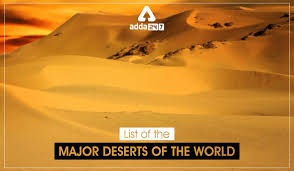

Original Paired Earcon 1:


Generated Earcon 1:


Image 2:


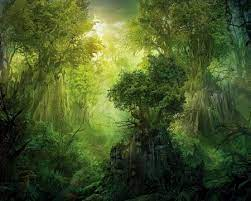

Original Paired Earcon 2:


Generated Earcon 2:


Image 3:


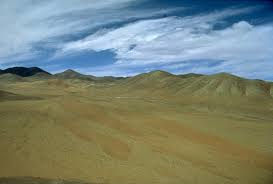

Original Paired Earcon 3:


Generated Earcon 3:


Image 4:


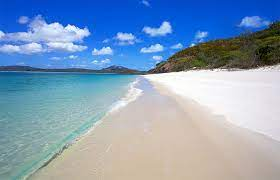

Original Paired Earcon 4:


Generated Earcon 4:


Image 5:


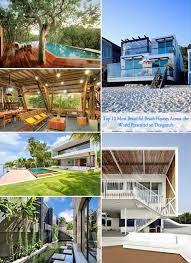

Original Paired Earcon 5:


Generated Earcon 5:


Image 6:


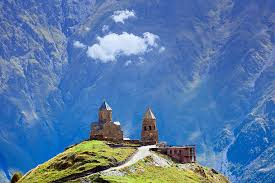

Original Paired Earcon 6:


Generated Earcon 6:


Image 7:


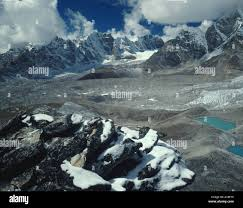

Original Paired Earcon 7:


Generated Earcon 7:


Image 8:


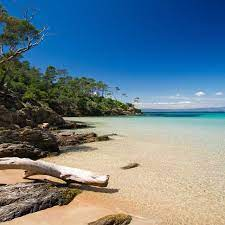

Original Paired Earcon 8:


Generated Earcon 8:


Image 9:


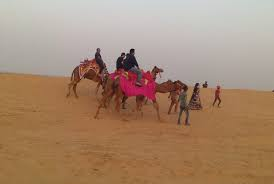

Original Paired Earcon 9:


Generated Earcon 9:


Image 10:


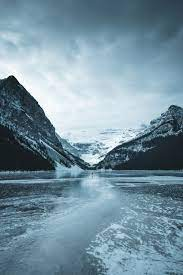

Original Paired Earcon 10:


Generated Earcon 10:


In [15]:
# display the images and play the audio for every pair
for i in range(len(elements)):
    # display image
    print(f"Image {i+1}:")
    display_image(test_df["image"].iloc[elements[i]])
    # play paired earcon
    print(f"Original Paired Earcon {i+1}:")
    play_audio(test_df["earcon"].iloc[elements[i]])
    # play generated earcon
    print(f"Generated Earcon {i+1}:")
    play_generated_audio(audio_list[i])